In [6]:
import pandas as pd
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df=pd.read_csv('../datasets/bioresponse.csv')
df.head()


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Split the dataset into training and testing sets
X = df.drop('Activity', axis=1)
y = df['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a shallow decision tree classifier
shallow_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
shallow_tree.fit(X_train, y_train)

# Predict on the test set
y_pred = shallow_tree.predict(X_test)

# Calculate accuracy
shallow_tree_accuracy = accuracy_score(y_test, y_pred)
shallow_tree_accuracy


0.7603195739014648

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss

# Calculate precision, recall, F1-score, and log-loss
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
y_pred_prob = shallow_tree.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_prob)

metrics_shallow_tree = {
    'Accuracy': shallow_tree_accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'Log-loss': logloss
}

metrics_shallow_tree


{'Accuracy': 0.7603195739014648,
 'Precision': 0.7868480725623582,
 'Recall': 0.8013856812933026,
 'F1-score': 0.7940503432494279,
 'Log-loss': 0.5370607267745985}

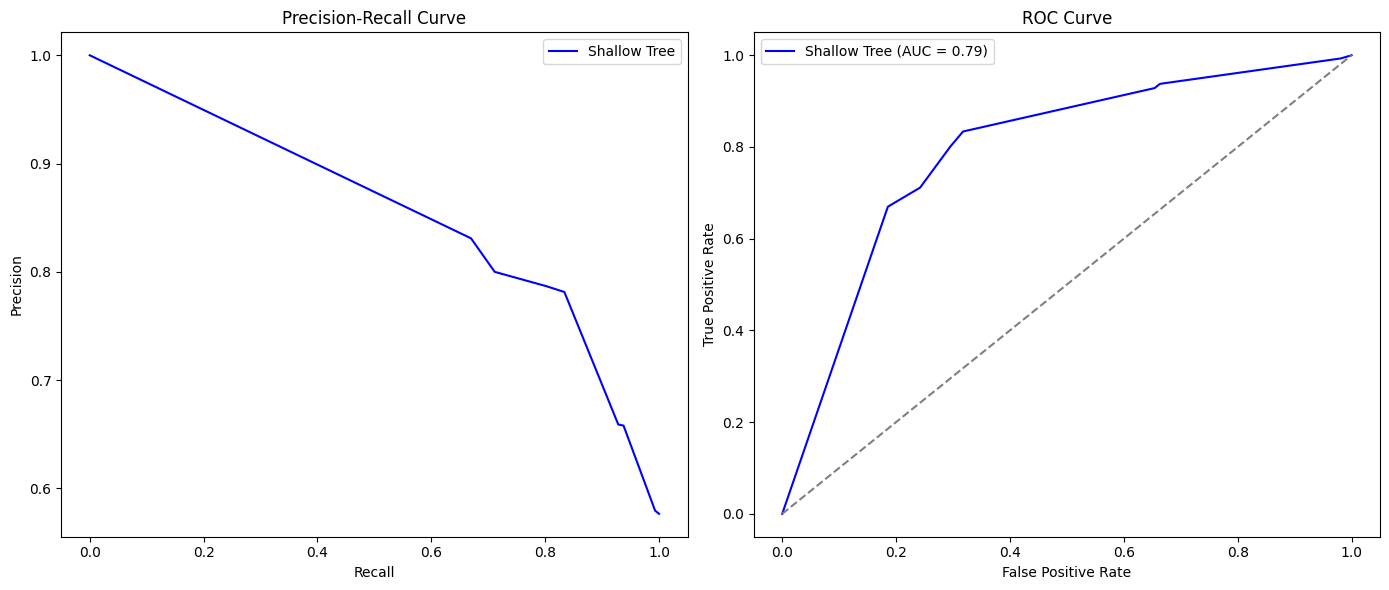

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Calculate Precision-Recall curve values for shallow decision tree
precision_values, recall_values, _ = precision_recall_curve(y_test, y_pred_prob[:, 1])

# Calculate ROC curve values for shallow decision tree
fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot Precision-Recall curve
plt.figure(figsize=(14, 6))

# Plotting Precision-Recall curve
plt.subplot(1, 2, 1)
plt.plot(recall_values, precision_values, label='Shallow Tree', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Plotting ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'Shallow Tree (AUC = {roc_auc:.2f})', color='b')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
from sklearn.linear_model import LogisticRegression

# Train a logistic regression model with L2 regularization
logistic_model = LogisticRegression(penalty='l2', max_iter=10000, random_state=42)
logistic_model.fit(X_train, y_train)

# Predict on the test set
y_pred_logistic = logistic_model.predict(X_test)
y_pred_prob_logistic = logistic_model.predict_proba(X_test)

# Calculate metrics
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic)
recall_logistic = recall_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic)
logloss_logistic = log_loss(y_test, y_pred_prob_logistic)

metrics_logistic = {
    'Accuracy': accuracy_logistic,
    'Precision': precision_logistic,
    'Recall': recall_logistic,
    'F1-score': f1_logistic,
    'Log-loss': logloss_logistic
}

metrics_logistic


{'Accuracy': 0.7536617842876165,
 'Precision': 0.7792792792792793,
 'Recall': 0.7990762124711316,
 'F1-score': 0.7890535917901939,
 'Log-loss': 0.6803162048791639}